Reconhecimento de Padrões

Lista 5: Árvores de Decisão e SVM

In [370]:
import optuna
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [357]:
bostonbin = pd.read_csv("content/bostonbin.csv", header=None)
print(bostonbin.shape)

new_columns = {old_col: f'x{i}' for i, old_col in enumerate(
    bostonbin.columns[:len(bostonbin.columns)])}
new_columns[bostonbin.columns[-1]] = 'target'

bostonbin = bostonbin.rename(columns=new_columns)
bostonbin.head()

(506, 18)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,target
0,2011.0,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,1.0
1,2021.0,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,1.0
2,2022.0,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,1.0
3,2031.0,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,1.0
4,2032.0,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,1.0


In [358]:
class Metrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

        TP = 0
        FP = 0
        FN = 0

        for i in range(len(self.y_pred)):
            if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
                TP += 1
            elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
                FP += 1
            elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
                FN += 1
        TN = len(self.y_true) - TP - FP - FN
        TP, FP, FN, TN

        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN

        self.accuracy = (self.TP + self.TN) / \
            (self.TP + self.FP + self.FN + self.TN)
        self.precision = self.TP / (self.TP + self.FP)
        self.recall = self.TP / (self.TP + self.FN)
        if (self.precision + self.recall) != 0:
            self.f1_score = 2 * (self.precision * self.recall) / \
                (self.precision + self.recall)

        self.confusion_matrix = np.array(
            [[self.TN, self.FN], [self.FP, self.TP]])

# Decision Tree

## Model

In [359]:
class Tree:
    def __init__(self, column=None, limiar=None, gini=None, left=None, right=None, is_leaf=False, leaf_value=None):
        # node
        self.column = column
        self.limiar = limiar
        self.gini = gini
        self.left = left
        self.right = right

        # leaf
        self.is_leaf = is_leaf
        self.leaf_value = leaf_value

In [360]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3, min_leaf_samples=3, gini_stop=0):
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.gini_stop = gini_stop
        self.tree = None
        self.classes_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes_ = np.unique(y)
        self.tree = self._train(X, y)
        return self

    def _train(self, X, y, current_depth=0):
        column, limiar, gini = self._gini_calculator(X, y)
        if column is None:
            leaf_value = np.bincount(y.astype(int)).argmax()
            return Tree(is_leaf=True, leaf_value=leaf_value)

        x_left = X[X[:, column] > limiar]
        y_left = y[X[:, column] > limiar]
        x_right = X[X[:, column] <= limiar]
        y_right = y[X[:, column] <= limiar]

        if (
            gini > self.gini_stop
            and current_depth < self.max_depth
            and len(x_left) >= self.min_leaf_samples
            and len(x_right) >= self.min_leaf_samples
        ):
            tree_left = self._train(x_left, y_left, current_depth + 1)
            tree_right = self._train(x_right, y_right, current_depth + 1)
            node = Tree(column=column, limiar=limiar,
                        gini=gini, left=tree_left, right=tree_right)
        else:
            leaf_value = np.bincount(y_left.astype(int)).argmax()
            node = Tree(is_leaf=True, leaf_value=leaf_value)

        return node

    def _gini_calculator(self, X, y):
        best_gini = float('inf')
        best_column = None
        best_limiar = None

        for column in range(X.shape[1]):
            if np.std(X[:, column]) == 0:
                continue

            limiares = np.unique(X[:, column])
            for limiar in limiares:
                y_left = y[X[:, column] > limiar]
                y_right = y[X[:, column] <= limiar]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gini_left = 1 - \
                    np.sum((np.bincount(y_left.astype(int)) / len(y_left)) ** 2)
                gini_right = 1 - \
                    np.sum((np.bincount(y_right.astype(int)) / len(y_right)) ** 2)
                gini = (len(y_left) * gini_left +
                        len(y_right) * gini_right) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_column = column
                    best_limiar = limiar

        if best_column is None:
            return None, None, None

        return best_column, best_limiar, best_gini

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse_tree(self.tree, row) for row in X])

    def _traverse_tree(self, node, row):
        if node.is_leaf:
            return node.leaf_value
        if row[node.column] > node.limiar:
            return self._traverse_tree(node.left, row)
        else:
            return self._traverse_tree(node.right, row)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def predict_proba(self, X):
        X = np.array(X)
        probas = np.array([self._proba_for_row(self.tree, row) for row in X])
        return probas

    def _proba_for_row(self, node, row):
        if node.is_leaf:
            probas = np.zeros(len(self.classes_))
            leaf_value = node.leaf_value
            probas[self.classes_ == leaf_value] = 1.0
            return probas

        if row[node.column] > node.limiar:
            return self._proba_for_row(node.left, row)
        else:
            return self._proba_for_row(node.right, row)

In [361]:
def plot_roc_pr(X, y, y_prob):
    # Obter as probabilidades de predição do melhor modelo
    # Probabilidade para a classe positiva (assumindo binário)

    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calcular a curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)

    # Plotar a Curva ROC
    plt.figure(figsize=(12, 6))

    # Subplot 1: Curva ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Subplot 2: Curva Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='b', lw=2,
             label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='lower left')

    # Exibir os plots
    plt.tight_layout()
    plt.show()

# Tree Grid Search

In [362]:
X = bostonbin.iloc[:, 0:-1]
y = bostonbin.iloc[:, -1]

model = DecisionTree()

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_leaf_samples': [1, 2, 3, 4, 5]
}

scoring = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=10, scoring=scoring)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTree(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_leaf_samples': [1, 2, 3, 4, 5]},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [363]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação:", grid_search.best_score_)

Melhores parâmetros: {'max_depth': 5, 'min_leaf_samples': 1}
Melhor pontuação de validação: 0.7887450980392157


In [364]:
metric = Metrics(y, grid_search.predict(X))

print('acuracy', metric.accuracy)
print('precision', metric.precision)
print('recall', metric.recall)
print('f1-score', metric.f1_score)

acuracy 0.8063241106719368
precision 0.8806584362139918
recall 0.7561837455830389
f1-score 0.8136882129277567


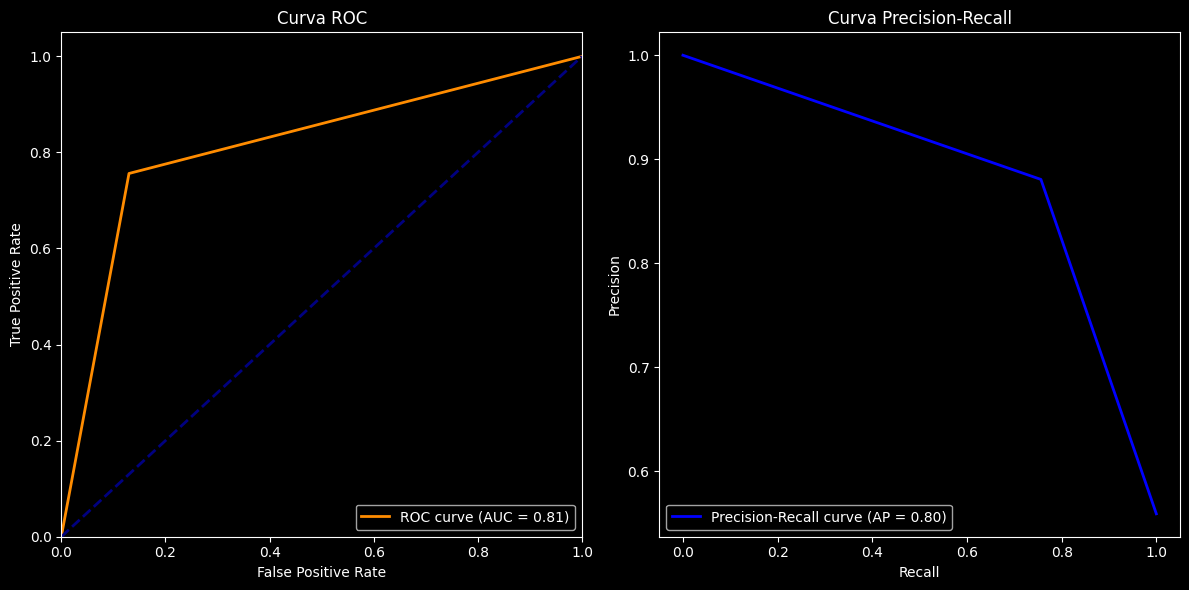

In [365]:
grid_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

plot_roc_pr(X, y, grid_proba)

## Tree Optuna

In [366]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_leaf_samples = trial.suggest_int('min_leaf_samples', 1, 5)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=101)

    model = DecisionTree(max_depth=max_depth,
                         min_leaf_samples=min_leaf_samples)

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-01-18 02:07:14,054] A new study created in memory with name: no-name-ca8dc085-f1be-482e-923e-624fd553797a
[I 2025-01-18 02:07:14,242] Trial 0 finished with value: 0.8421052631578947 and parameters: {'max_depth': 2, 'min_leaf_samples': 1}. Best is trial 0 with value: 0.8421052631578947.
[I 2025-01-18 02:07:14,369] Trial 1 finished with value: 0.8421052631578947 and parameters: {'max_depth': 1, 'min_leaf_samples': 4}. Best is trial 0 with value: 0.8421052631578947.
[I 2025-01-18 02:07:14,628] Trial 2 finished with value: 0.743421052631579 and parameters: {'max_depth': 3, 'min_leaf_samples': 1}. Best is trial 0 with value: 0.8421052631578947.
[I 2025-01-18 02:07:14,818] Trial 3 finished with value: 0.8421052631578947 and parameters: {'max_depth': 2, 'min_leaf_samples': 2}. Best is trial 0 with value: 0.8421052631578947.
[I 2025-01-18 02:07:15,133] Trial 4 finished with value: 0.8223684210526315 and parameters: {'max_depth': 4, 'min_leaf_samples': 1}. Best is trial 0 with value: 0.

Best hyperparameters: {'max_depth': 10, 'min_leaf_samples': 1}


In [367]:
optuna_model = DecisionTree(**best_params)
optuna_model.fit(X, y)

DecisionTree(max_depth=10, min_leaf_samples=1)

In [368]:
metric = Metrics(y, optuna_model.predict(X))

print('acuracy', metric.accuracy)
print('precision', metric.precision)
print('recall', metric.recall)
print('f1-score', metric.f1_score)

acuracy 0.8675889328063241
precision 0.8439490445859873
recall 0.9363957597173145
f1-score 0.8877721943048578


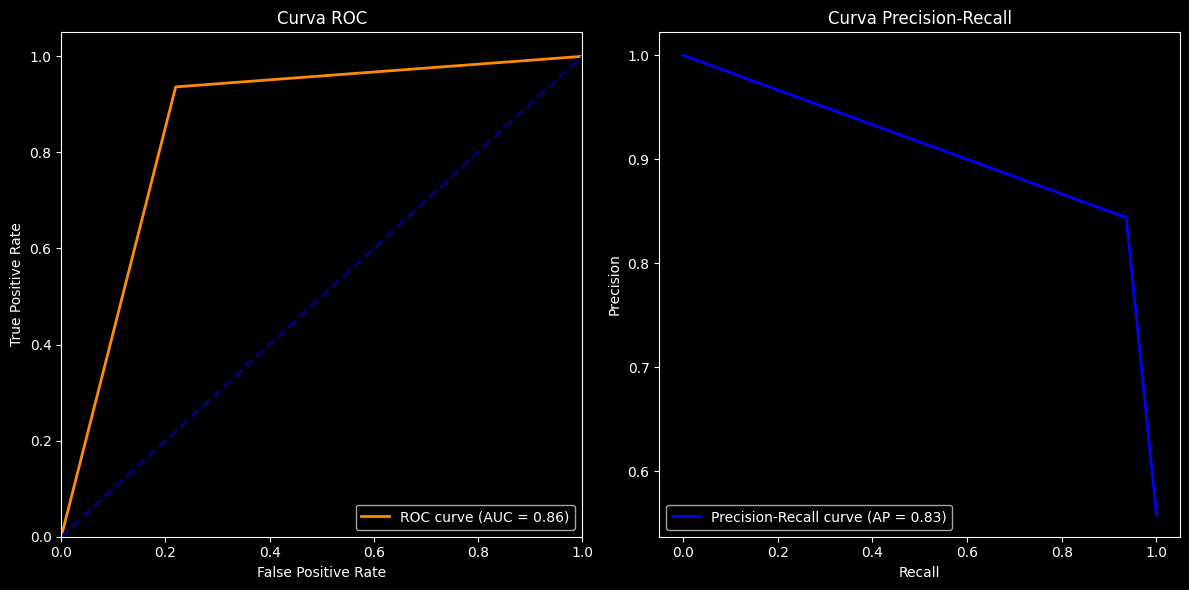

In [369]:
proba_predictions = optuna_model.predict_proba(X)[:, 1]
plot_roc_pr(X, y, proba_predictions)

# SVM Grid Search

In [388]:
X = bostonbin.iloc[:, 0:-1]
y = bostonbin.iloc[:, -1]

model = svm.SVC(kernel="rbf", probability=True)

param_grid = {
    "C": [2**x for x in range(-5, 16)],
    "gamma": [2**x for x in range(-15, 4)],
}

scoring = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=10, scoring=scoring)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64, 128, 256, 512, 1024, 2048, 4096,
                               8192, 16384, 32768],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [376]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação:", grid_search.best_score_)

Melhores parâmetros: {'C': 1, 'gamma': 0.01}
Melhor pontuação de validação: 0.5610588235294118


In [377]:
metric = Metrics(y, grid_search.predict(X))

print('acuracy', metric.accuracy)
print('precision', metric.precision)
print('recall', metric.recall)
print('f1-score', metric.f1_score)

acuracy 0.9762845849802372
precision 0.9754385964912281
recall 0.9823321554770318
f1-score 0.9788732394366197


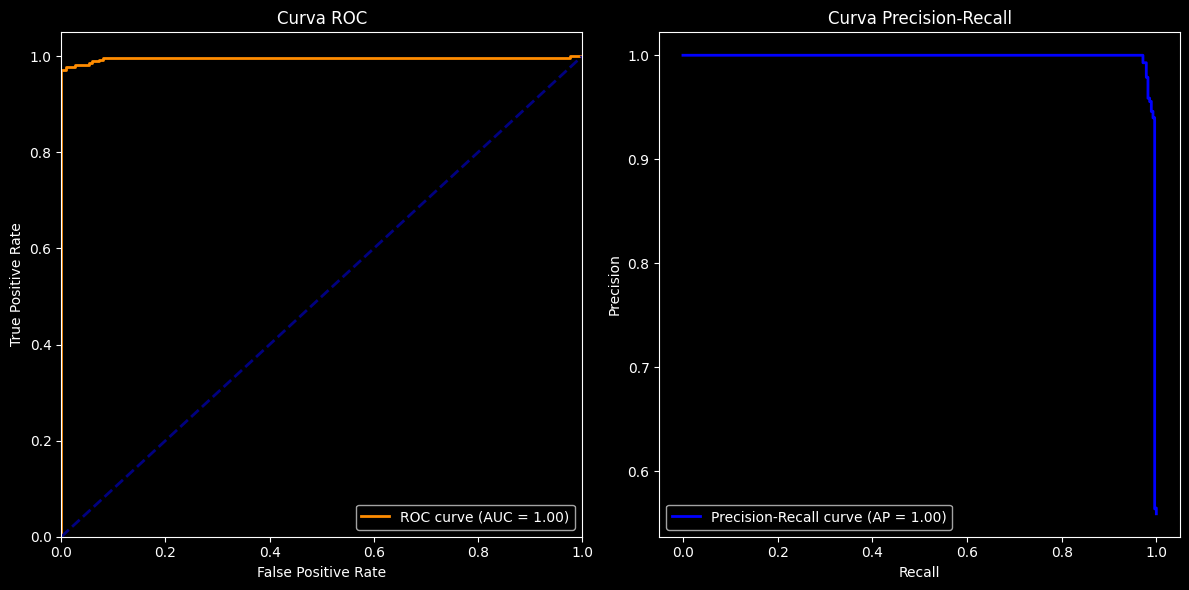

In [378]:
grid_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

plot_roc_pr(X, y, grid_proba)

## SVM Optuna

In [379]:
def objective(trial):
    C_values = [2**x for x in range(-5, 16)]
    gamma_values = [2**x for x in range(-15, 4)]

    C = trial.suggest_categorical('C', C_values)
    gamma = trial.suggest_categorical('gamma', gamma_values)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=101)

    model = svm.SVC(C=C, gamma=gamma)

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-01-18 02:28:04,750] A new study created in memory with name: no-name-da44c2d0-2b1a-4e8e-b970-f19ee0047d36
[I 2025-01-18 02:28:04,772] Trial 0 finished with value: 0.6578947368421053 and parameters: {'C': 89, 'gamma': 6}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-01-18 02:28:04,792] Trial 1 finished with value: 0.6578947368421053 and parameters: {'C': 50, 'gamma': 7}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-01-18 02:28:04,810] Trial 2 finished with value: 0.6578947368421053 and parameters: {'C': 68, 'gamma': 9}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-01-18 02:28:04,828] Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 80, 'gamma': 5}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-01-18 02:28:04,849] Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 36, 'gamma': 4}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-01-18 02:28:04,870] Trial 5 finished with value: 0.657894736842

Best hyperparameters: {'C': 89, 'gamma': 6}


In [385]:
optuna_model = svm.SVC(**best_params,  probability=True)
optuna_model.fit(X, y)

SVC(C=89, gamma=6, probability=True)

In [386]:
metric = Metrics(y, optuna_model.predict(X))

print('acuracy', metric.accuracy)
print('precision', metric.precision)
print('recall', metric.recall)
print('f1-score', metric.f1_score)

acuracy 1.0
precision 1.0
recall 1.0
f1-score 1.0


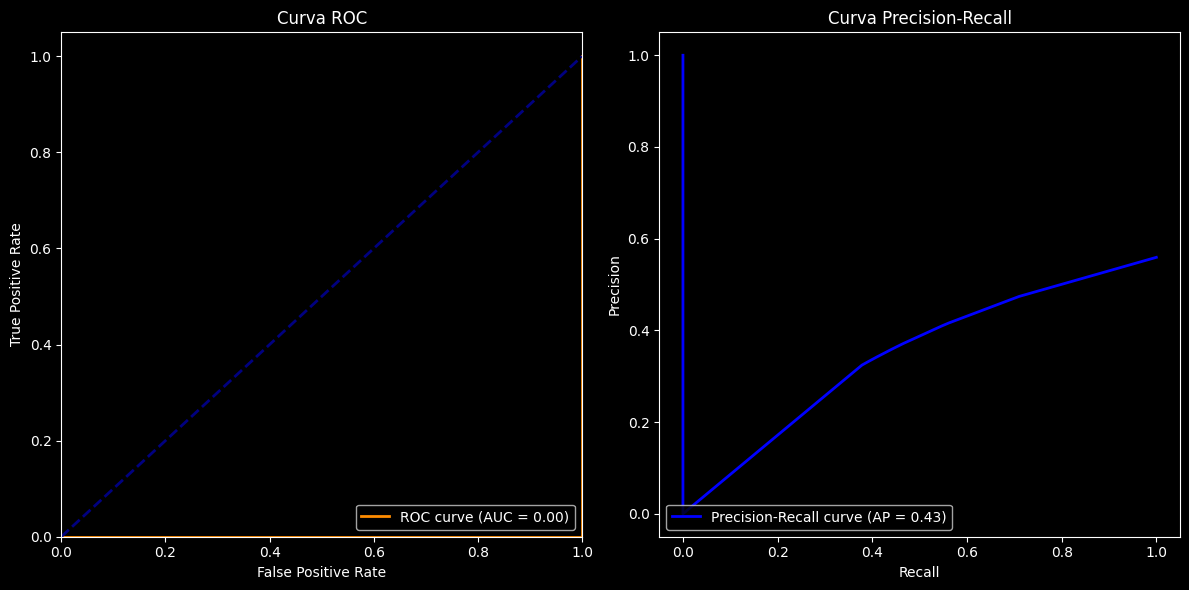

In [387]:
proba_predictions = optuna_model.predict_proba(X)[:, 1]
plot_roc_pr(X, y, proba_predictions)